Detailed documentation of this notebook can be found here: https://github.com/junyoung-sim/gbm

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sp
import matplotlib.pyplot as plt
from download import download

np.set_printoptions(suppress=True)

In [2]:
OBS = 100 # observation period
EXT = 20 # extrapolation period
EPOCH = 1000 # number of simulations

In [3]:
ticker = input("Ticker: ")
apikey = open("apikey", "r").readline()
raw = download(ticker, apikey)
print(raw)

Ticker: ^VIX
            date   adjClose
0     2000-01-03  24.209999
1     2000-01-04  27.010000
2     2000-01-05  26.410000
3     2000-01-06  25.730000
4     2000-01-07  21.719999
...          ...        ...
6006  2023-11-02  15.660000
6007  2023-11-03  14.910000
6008  2023-11-06  14.890000
6009  2023-11-07  14.810000
6010  2023-11-08  14.450000

[6011 rows x 2 columns]


^VIX P&L
                 0
count  6010.000000
mean      0.002465
std       0.073944
min      -0.295727
25%      -0.039091
50%      -0.005331
75%       0.034083
max       1.155979


[Text(0.5, 0, '^VIX P&L'), Text(0, 0.5, 'Frequency')]

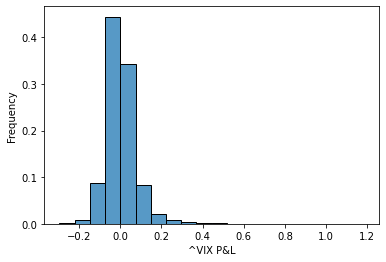

In [4]:
t0 = np.array(raw["adjClose"][0:-1])
t1 = np.array(raw["adjClose"][1:])
returns = (t1 - t0) / t0

returns = np.array(returns)
raw = raw.iloc[1:]

print("{} P&L" .format(ticker))
print(pd.DataFrame(returns).describe())

ax = sns.histplot(data=returns, binwidth=np.std(returns), stat="probability")
ax.set(xlabel="{} P&L" .format(ticker), ylabel="Frequency")

In [5]:
valuation_series = []
recent_simulations = []

In [6]:
for T in range(OBS-1, raw.shape[0]):
    s0 = raw["adjClose"][T] # current value
    mu = returns[T+1-OBS:T+1].mean() # mean daily return
    sigma = np.std(returns[T+1-OBS:T+1]) # variability in daily returns
    drift = mu + 0.5 * sigma**2 # drift of random walk
    
    brownian = np.random.normal(0, 1, (EPOCH, EXT)) # brownian shock values
    brownian = np.cumsum(brownian, axis=1)
    
    t = np.arange(1, EXT+1) # extrapolation time
    path = s0 * np.exp(drift * t + sigma * brownian) # simulated paths
    
    # P(s_t > s0 | t E {1, 2, 3, ... , EXT}) (valuation score)
    score = float(sum(path.flatten() > s0)) / (EPOCH * EXT)
    valuation_series.append(score)
    
    if T == raw.shape[0] - 1: # save recent simulations
        recent_simulations = np.insert(path, 0, s0, axis=1)
    
    #print("T={} @ {} VAL={}" .format(T, ticker, score))

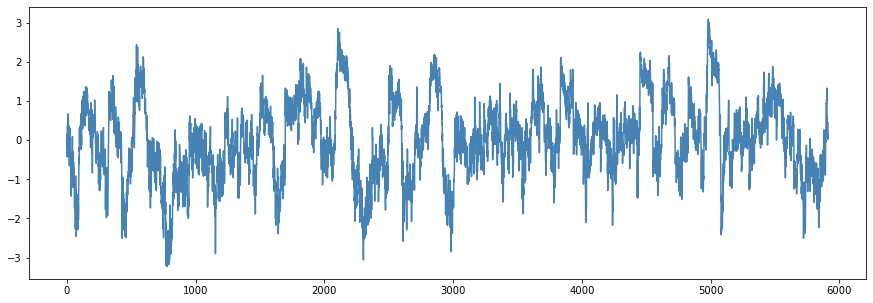

In [10]:
valuation_series = np.array(valuation_series)
valuation_series = (valuation_series - valuation_series.mean()) / np.std(valuation_series)
plt.figure(figsize=(15,5))
plt.plot(valuation_series, color="steelblue", label="valuation")
#plt.ylim(0, 1)
plt.show()

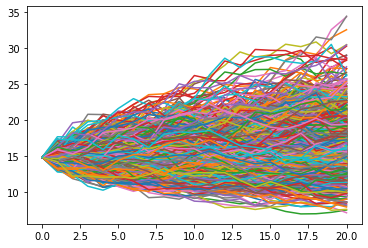

In [8]:
for path in recent_simulations:
    plt.plot(path)
plt.show()